This notebook walks the user through the process of creating an automatic alignment pipeline, for use in the Video Analysis notebook. You will need a pair of images or videos, one from the visible and one from the ultraviolet camera. It is best to select a pair that contain a number of easily distinguishable marks, as we will need to select common points in each image to create the coarse alignment.

In [1]:
import video2vision as v2v
import numpy as np
from PIL import Image
from utils import get_size
import widgets

# Path to the visible image or video
VIS_PATH = '/data/hot/color/camera_data/2022-04-14/VIS/VIS02148.JPG'
# Path to the ultraviolet image or video
UV_PATH = '/data/hot/color/camera_data/2022-04-14/UV/UV_02290.JPG'
# Path to write the resulting alignment pipeline
OUT_PATH = 'alignment_pipeline.json'
# Whether to build a still alignment pipeline or a video alignment pipeline
BUILD_VIDEO_PIPELINE = False

We need to select a number of tie points in each image. A tie point is a pair of points, one in the visible image and one in the ultraviolet image, where the point in the picture corresponds to the same point in the physical world. The ideal tie points are precise and easily distinguishable, for example, the corners of a notecard. It is best to be as precise as possible, but exact accuracy is not needed. First, select the tie points in the visible image below.

In [2]:
image_size = get_size(VIS_PATH)
vis_reader = v2v.Loader(VIS_PATH, image_size)
vis_selector = widgets.SelectorBox(vis_reader, 0, 10, box_color=(0, 255, 255))

display(vis_selector)

SelectorBox(children=(SampleSelector(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\xf1\x00\x00\x03\x…

Now do it again for the ultraviolet image. Make sure to select the tie points in the same order.

In [3]:
uv_reader = v2v.Loader(UV_PATH, image_size)
uv_selector = widgets.SelectorBox(uv_reader, 0, 10, box_color=(0, 255, 255))

display(uv_selector)

SelectorBox(children=(SampleSelector(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\xf1\x00\x00\x03\x…

We will now use those tie points to calculate a coarse alignment, and display the aligned ultraviolet next to the visible image. It is **not** necessary that the alignment be exact at this stage; it just needs to be approximately correct. If it is not, restart the notebook and try again.

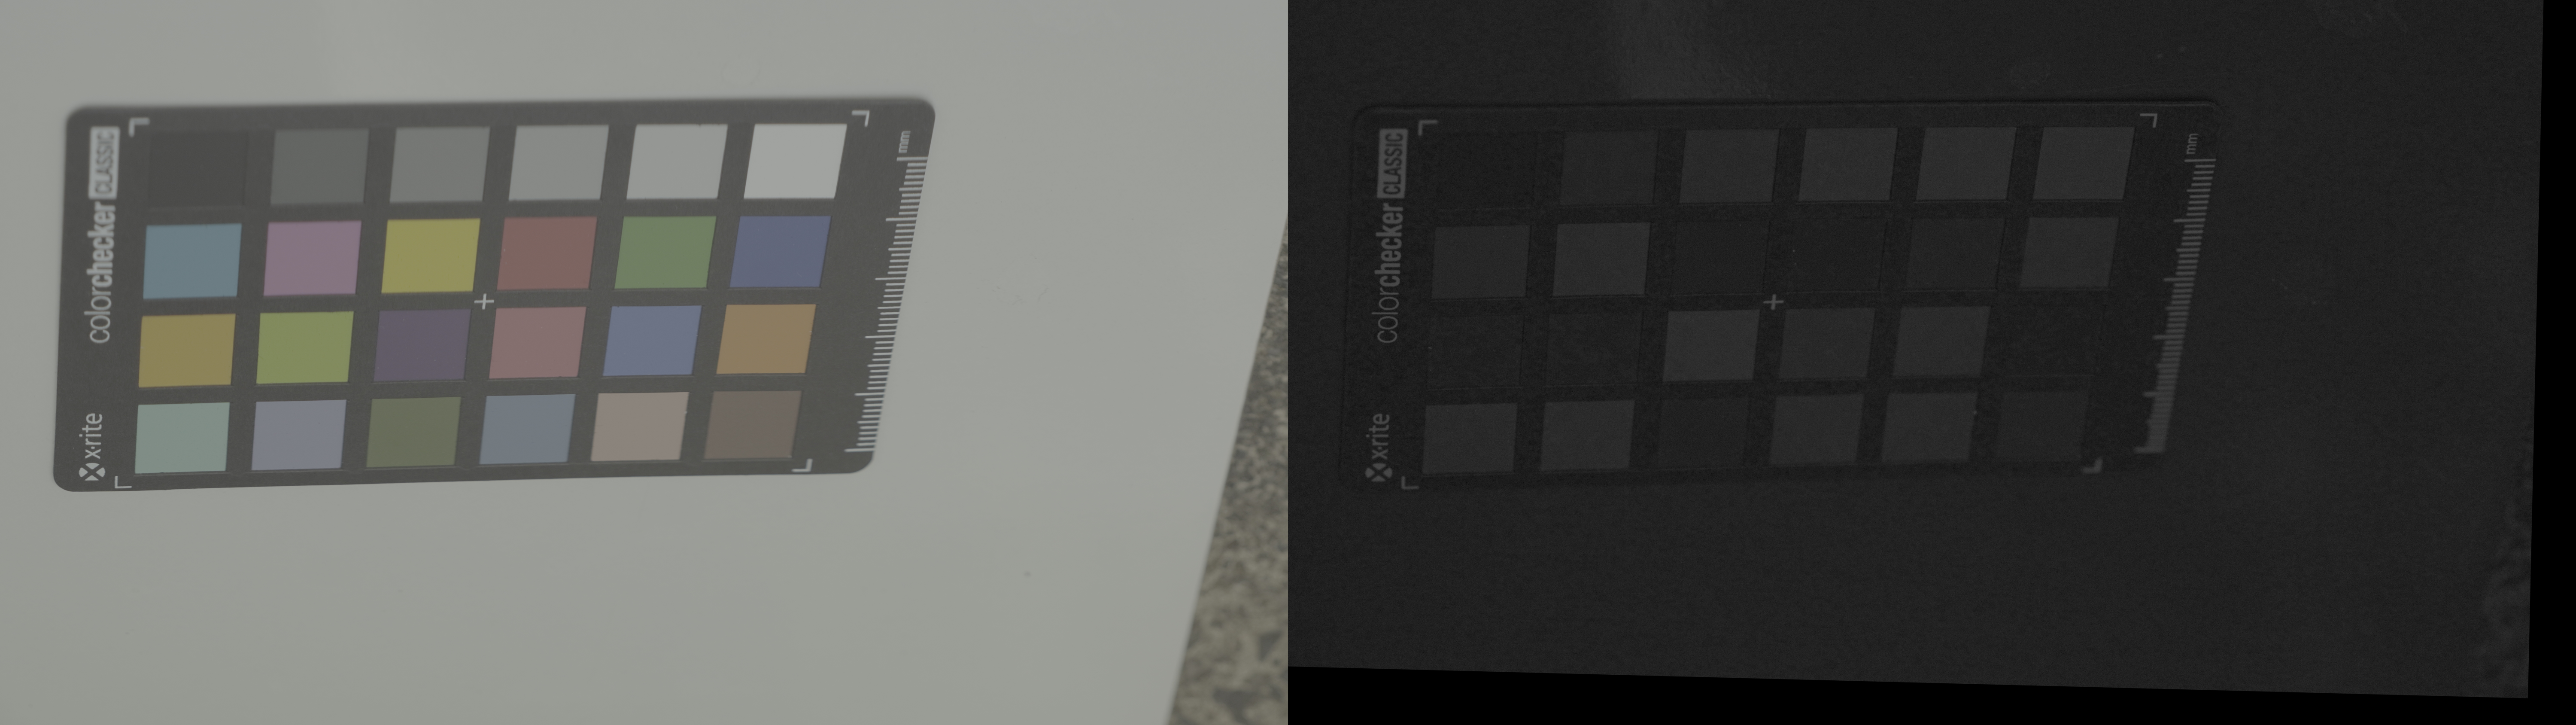

In [4]:
warp_op = v2v.Warp.build_from_tiepoints(
    uv_selector.crosshairs,
    vis_selector.crosshairs,
    image_size,
)

w, h = image_size
display_image = Image.new('RGB', (2 * w, h))
vis_image = np.clip(255 * vis_selector._cached_image, 0, 255,).astype(np.uint8)
display_image.paste(Image.fromarray(vis_image[..., [2, 1, 0]]), (0, 0))
uv_image = warp_op({'image': uv_selector._cached_image})['image']
uv_image = np.clip(255 * uv_image, 0, 255).astype(np.uint8)
display_image.paste(Image.fromarray(uv_image[..., 0], 'L'), (w, 0))
# We shrink the image because too large an image can sometimes fail to display
display(display_image.resize((w, h // 2)))

We then build the alignment and save it. Once this cell is run, you can proceed to Video-Analysis.

In [5]:
pipe = v2v.Pipeline()
uv_loader_idx = pipe.add_operator(v2v.Loader(None, image_size))
vis_loader_idx = pipe.add_operator(v2v.Loader(None, image_size))
coarse_align_idx = pipe.add_operator(warp_op)
if BUILD_VIDEO_PIPELINE:
    align_op = v2v.AutoTemporalAlign(time_shift_range=[-10, 10], bands=[[0, 1, 2], []])
else:
    align_op = v2v.AutoAlign(num_votes=4, bands=[[0, 1, 2], []])
fine_align_idx = pipe.add_operator(align_op)
writer_idx = pipe.add_operator(v2v.Writer(extension=('mp4' if BUILD_VIDEO_PIPELINE else 'png')))
pipe.add_edge(uv_loader_idx, coarse_align_idx, in_slot=0)
pipe.add_edge(vis_loader_idx, fine_align_idx, in_slot=1)
pipe.add_edge(coarse_align_idx, fine_align_idx, in_slot=0)
pipe.add_edge(fine_align_idx, writer_idx, in_slot=0)
pipe.save(OUT_PATH)